In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load brain3 data

In [3]:
realigned=False
obs = abc.get_combined_metadata(realigned=False, version="20230830", drop_unused=False)

In [4]:
ccf_polygons = abc.get_ccf_labels_image(resampled=True, realigned=realigned)
if realigned:
    ccf_label = 'parcellation_substructure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_substructure'
    coords = 'reconstructed'

### preprocessing

In [5]:
th_names = abc.get_thalamus_substructure_names()
th_subregion_names = list(set(th_names).difference(['TH-unassigned']))

In [6]:
# remove non-neuronal and some other outlier non-thalamus types
obs_neurons = abc.filter_adata_by_class(obs, filter_midbrain=False)

In [7]:
# filter to CCF using thalamus outline with a small buffer (slower)
obs_th = abc.label_thalamus_spatial_subset(obs, distance_px=5, realigned=realigned, filter_cells=True)

# subset just the neurons
obs_th_neurons = obs.loc[obs_neurons.index.intersection(obs_th.index)]
obs_th_strict = obs_th_neurons.loc[lambda df: df[ccf_label].isin(th_names)]

In [8]:
section_col = 'z_section'
sections_all = sorted(obs_th_neurons[section_col].unique())
# pick 3 example sections
sections_3 = [6.4, 7.2, 8.0]

In [9]:
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_polygons, distance_px=1, fill_val=0, 
                                                return_edges=True, section_list=sections_int
                                                )

## view CCF

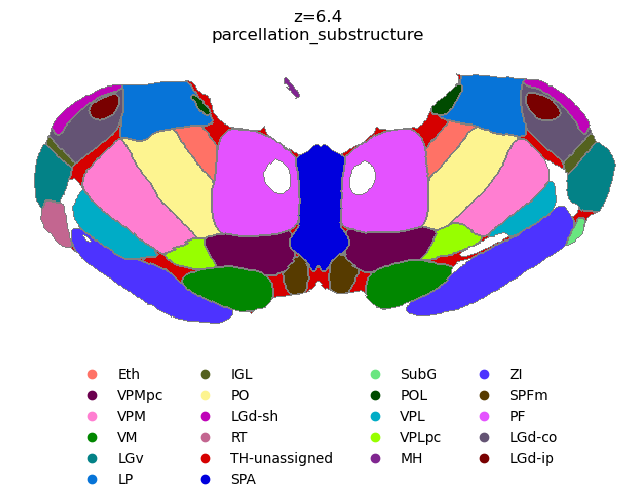

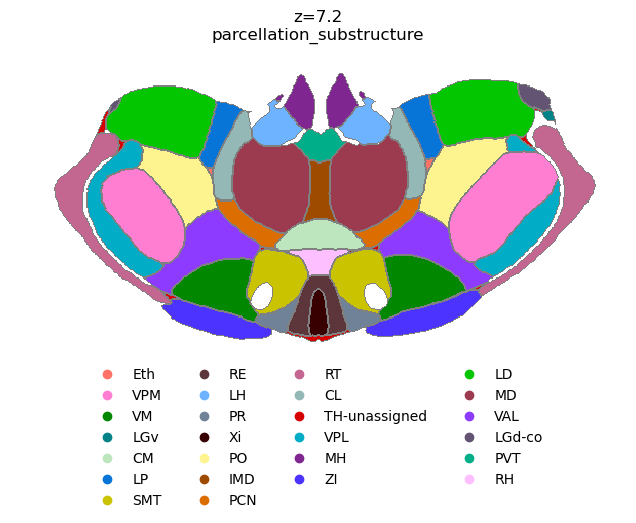

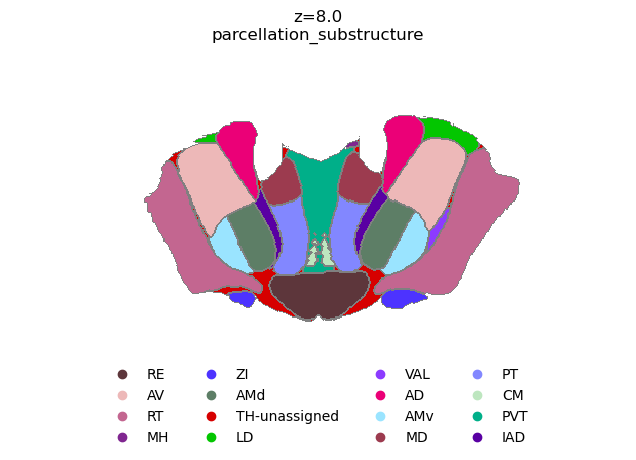

In [10]:
cplots.plot_ccf_overlay(obs_th_neurons.iloc[[],:], # no foreground cells; just the ccf shapes
                        ccf_polygons, sections=sections_3, point_hue=ccf_label, 
                        highlight='all', legend='ccf',
                        section_col=section_col,
                        x_col = 'x_'+coords,
                        y_col = 'y_'+coords,
                        bg_shapes=False, min_section_count=0, 
                        boundary_img=ccf_boundaries);

## view taxonomy labels over CCF

### select thalamus celltype subsets

In [11]:
subclasses_all = obs_th_strict['subclass'].value_counts().loc[lambda x: x>100].index
print(len(subclasses_all))

supertypes_all = obs_th_strict['supertype'].value_counts().loc[lambda x: x>20].index
print(len(supertypes_all))

21
103


In [12]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all), 'class'].value_counts()

class
18 TH Glut           58157
12 HY GABA           13925
17 MH-LH Glut         5703
19 MB Glut            3816
20 MB GABA            2461
25 Pineal Glut           0
08 CNU-MGE GABA          0
10 LSX GABA              0
32 OEC                   0
07 CTX-MGE GABA          0
15 HY Gnrh1 Glut         0
01 IT-ET Glut            0
06 CTX-CGE GABA          0
34 Immune                0
14 HY Glut               0
16 HY MM Glut            0
21 MB Dopa               0
02 NP-CT-L6b Glut        0
31 OPC-Oligo             0
33 Vascular              0
03 OB-CR Glut            0
30 Astro-Epen            0
29 CB Glut               0
28 CB GABA               0
27 MY GABA               0
26 P GABA                0
24 MY Glut               0
23 P Glut                0
13 CNU-HYa Glut          0
11 CNU-HYa GABA          0
09 CNU-LGE GABA          0
05 OB-IMN GABA           0
04 DG-IMN Glut           0
22 MB-HB Sero            0
Name: count, dtype: int64

In [13]:
supertypes_from_subclasses = obs_th_neurons.loc[
    lambda df: df['subclass'].isin(subclasses_all), 'supertype'].unique()
supertypes_from_subclasses.shape[0]

100

In [14]:
len(supertypes_all.intersection(supertypes_from_subclasses))

94

In [15]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all), 'cluster'].unique().shape[0]

455

### Plots

In [16]:
palettes = {level: abc.get_taxonomy_palette(level) for level in 
            ['subclass','supertype','cluster']}

In [17]:

kwargs = dict(
    bg_cells=obs_th_strict,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=3, 
    shape_palette='dark_outline',
    boundary_img=ccf_boundaries
)

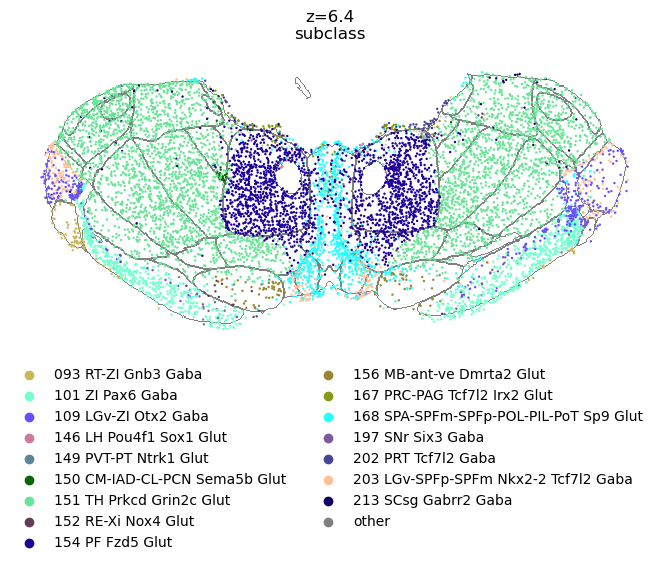

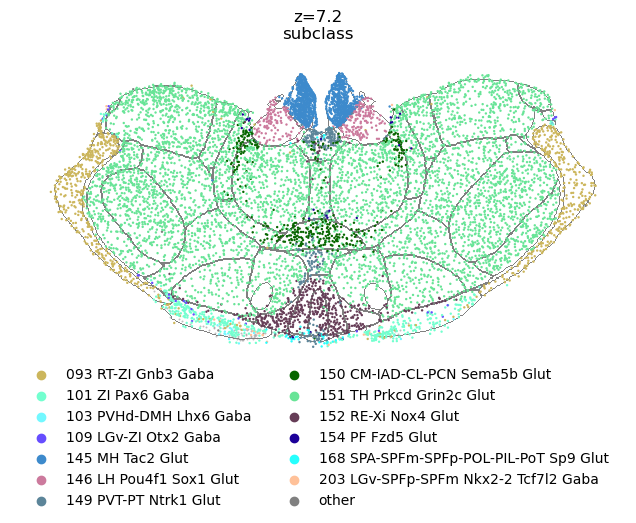

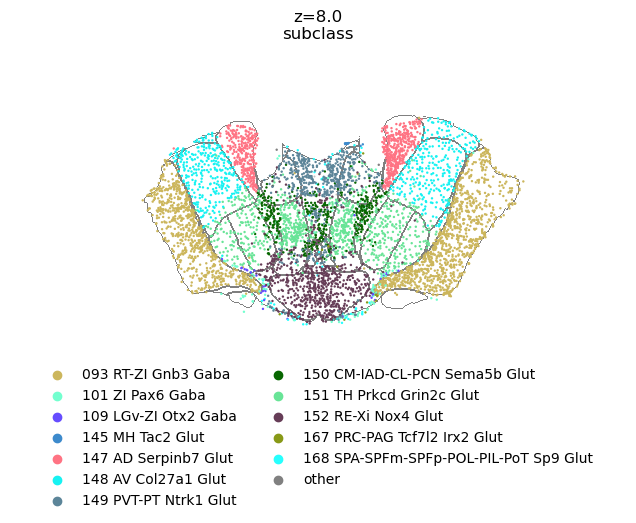

In [18]:
obs = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all)]
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        point_hue='subclass', sections=sections_3,
                        point_palette=palettes['subclass'],
                        legend='cells', 
                        **kwargs);

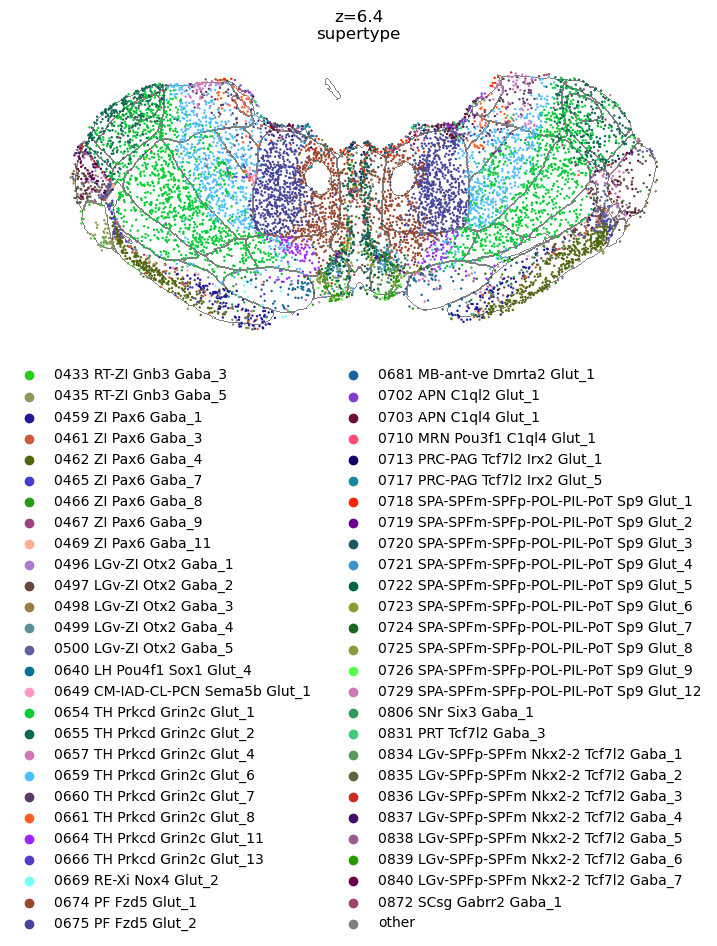

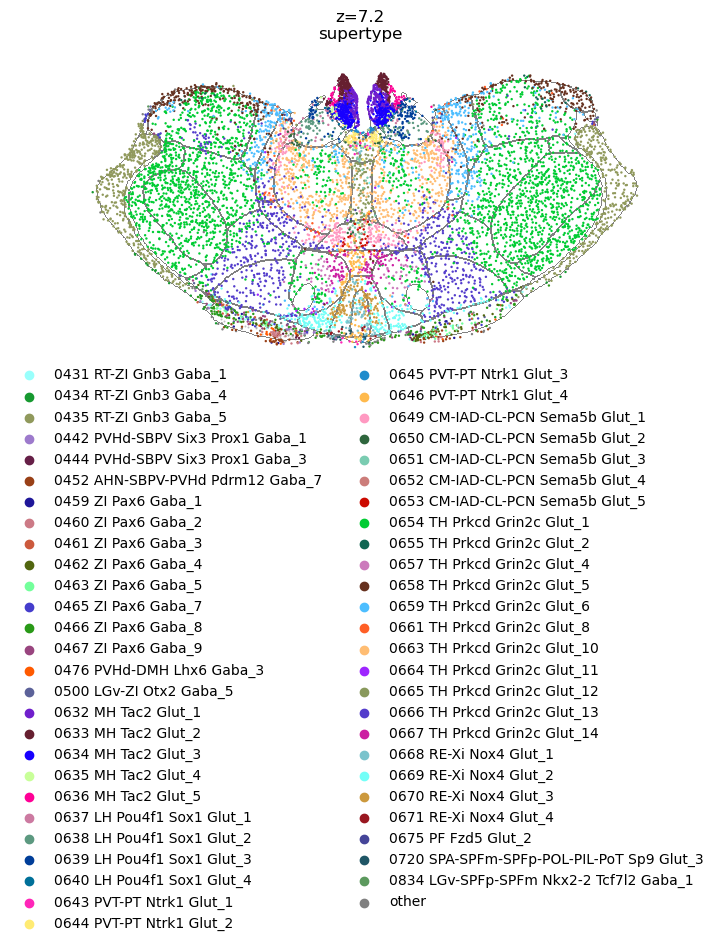

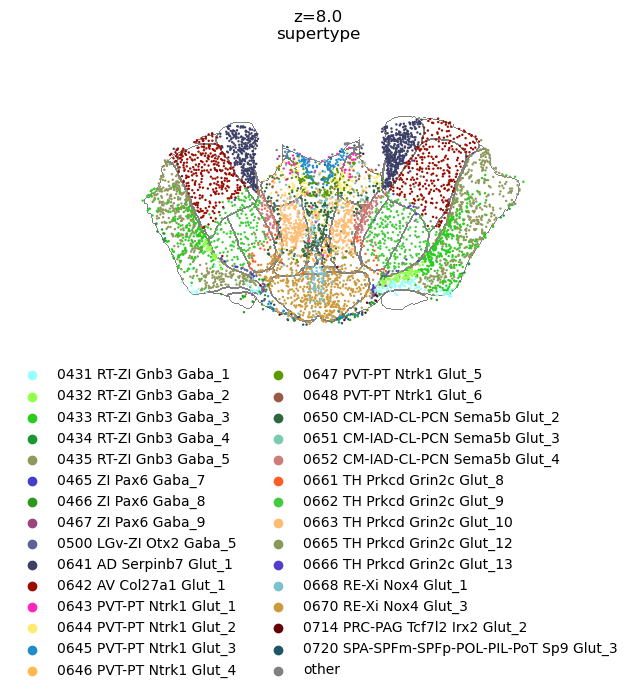

In [19]:
# TODO: this is not a good palette! maybe make supertypes of a subtype the same hue?
obs = obs_th_neurons.loc[lambda df: df['supertype'].isin(supertypes_all)]
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        point_hue='supertype', sections=sections_3,
                        point_palette=palettes['supertype'],
                        legend='cells', 
                        **kwargs);

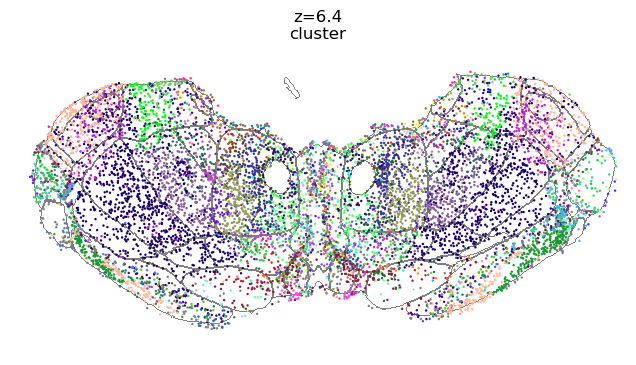

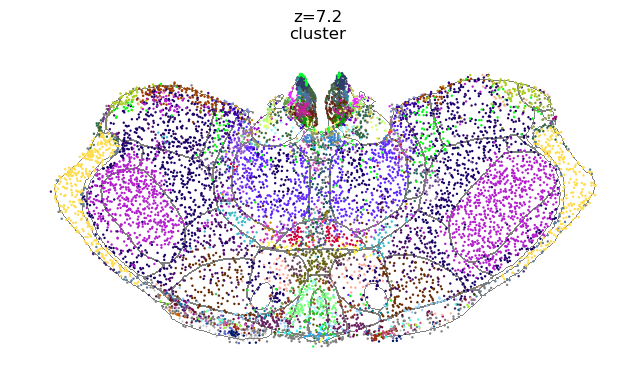

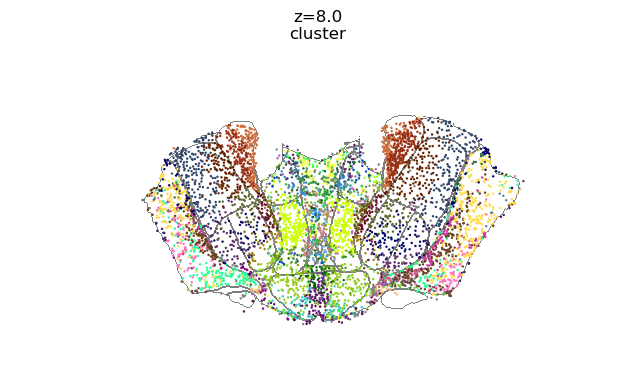

In [20]:
obs = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all)]
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        point_hue='cluster', sections=sections_3,
                        point_palette=palettes['cluster'],
                        legend=None, 
                        **kwargs);

## subclass view of all sections

In [ ]:
obs = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all)]
cplots.plot_ccf_overlay(obs, ccf_polygons, 
                        point_hue='subclass', point_palette=palettes['subclass'],
                        min_group_count=30,
                        **kwargs);

## specific nuclei examples

### ANT

#### supertypes

In [ ]:
sections = [8.0]
clusters = [str(x) for x in list(range(2613, 2616+1)) + list(range(2674, 2676+1))]
obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
nuclei = ['AD', 'AV', 'AMd', 'AMv']

cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='supertype', point_palette=palettes['supertype'],
                        sections=sections,
                        ccf_names=nuclei, legend='cells',
                        **kwargs);

In [ ]:
# or plot all sections based on the selected cells
cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='supertype', point_palette=palettes['supertype'],
                        sections=None,
                        ccf_names=nuclei, legend='cells',
                        **kwargs);

#### clusters

In [ ]:
cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='cluster', point_palette=palettes['cluster'],
                        sections=sections,
                        ccf_names=nuclei, legend='cells',
                        **kwargs);

### VAL + VM (clusters)

In [ ]:

sections = [7.2, 7.0, 6.8]
clusters = ['2683','2684','2687']
obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
nuclei = ['VM','VAL']
cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='cluster', point_palette=palettes['cluster'],
                        sections=sections,
                        ccf_names=nuclei, legend='cells',
                        **kwargs);

### PVT

#### supertypes in one subclass

In [ ]:
sections = [6.6, 7.8, 8.2]
nuclei = ['PVT']
# subclasses annotated as PVT
obs = obs_th_neurons.loc[np.any([obs_th_neurons['subclass'].str.contains(x).values for x in nuclei], axis=0), :]
cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='supertype', point_palette=palettes['supertype'],
                        sections=sections,
                        ccf_names=nuclei, legend='cells',
                        **kwargs);

### RT

#### supertypes in one subclass

In [ ]:
sections = [7.2, 7.8]
nuclei = ['RT','ZI']
match = 'RT-ZI'
obs = obs_th_neurons.loc[obs_th_neurons['subclass'].str.contains(match)]
cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='supertype', point_palette=palettes['supertype'],
                        sections=sections,
                        ccf_names=nuclei, legend='cells',
                        **kwargs);

## other nuclei from annotations

### PT

In [ ]:
nucleus='PT'
obs = abc.get_obs_from_annotated_clusters(nucleus, obs_th_neurons)

cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='supertype', point_palette=palettes['supertype'],
                        ccf_names=[nucleus],
                        **kwargs);

### LGd

In [ ]:

nuclei=['LGd-co', 'LGd-ip', 'LGd-sh']
obs = abc.get_obs_from_annotated_clusters('LGd', obs_th_neurons)

cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='cluster', point_palette=palettes['cluster'],
                        ccf_names=nuclei,
                        **kwargs);

### SMT

In [ ]:
nucleus='SMT'
obs = abc.get_obs_from_annotated_clusters(nucleus, obs_th_neurons)

cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='cluster', point_palette=palettes['cluster'],
                        ccf_names=[nucleus],
                        **kwargs);

### LD

In [ ]:
nucleus='LD'
obs = abc.get_obs_from_annotated_clusters(nucleus, obs_th_neurons)

cplots.plot_ccf_overlay(obs, ccf_polygons,
                        point_hue='cluster', point_palette=palettes['cluster'],
                        ccf_names=[nucleus],
                        **kwargs);

### PVT-IMD overlap

In [ ]:
# by annotation
obs = pd.concat([
    abc.get_obs_from_annotated_clusters('PVT', obs_th_neurons),
    abc.get_obs_from_annotated_clusters('PVT IMD', obs_th_neurons)
])
nuclei = ['PVT','IMD']
# by subclass (excluding)
# obs = obs_th_neurons.loc[lambda df: df['subclass'].str.contains('PVT')]
# obs = obs.loc[obs.index.difference(obs_anno.index)]

# by cluster
# clusters = ['2617','2629']
# obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]

cplots.plot_ccf_overlay(obs, ccf_polygons,
                        min_group_count=0,min_section_count=20,
                        point_hue='cluster', point_palette=palettes['cluster'],
                        ccf_names=nuclei, 
                        **kwargs);